## Assignment1-ML-for-NLP2
For this assignment, you will work in groups. (See group assignment below.) 
Use the samples of Twitter data posted in the Input folder (corresponding to NYT and Fox News) and do the following:


1. Data cleaning. 

Remove stopwords, links, hashtags, etc. 

2. Feature engineering.

Create popularity and engagement measures, mentions (i.e. a tweet includes @), popular hashtags, breaking news, growth of followers, an indicator if the tweet is posted by NYT, and zero if the tweet belongs to Fox News.

- popularity measures: likes, likes per retweets, likes per followers
- engagement measures: replies+quote_count, replies+quote_count per followers
- number of other accounts' mentions (@)
- popular hashtags
- tweets' special categories: breaking news, opinion
- is_nyt

3. Data Exploration and Prediction
- Is there a follower-tweet relationship? 
- What are the most frequent topics tweeted about by each outlet? Are there differences in outlets?
- Is there a relationship between the sentiment of the tweet and the outlet?
- Can we predict the outlet by the text of the tweet? Use classif micationethods (Naive Bayes, Logistic Regression, Support Vector Classifier using Count Vectorizer, Tf-Idf, or Word Embeddings). Which method performs better? Why?
- Do the usual word analogies hold in this sample?
- Create the most representative tweet by outlet (See  https://www.youtube.com/watch?v=zFScws0mb7M&t=23m03s and the Q&A for his description of it is implemented in the algorithm.)

Bonus 10 points: Create at least two own explorations.

Create a GitHub repository with your code and invite me to it. 


In [45]:
import numpy as np
from numpy import array
import pandas as pd
import regex as re

In [27]:
df1 = pd.read_csv('Inputs/FoxNews_all_tweets.csv')
df2 = pd.read_csv('Inputs/nytimes_all_tweets.csv')

# merging two datasets for simplicity
frames = [df1, df2]
df = pd.concat(frames, ignore_index= True)
df.head()

,author_id,username,author_followers,author_tweets,author_description,author_location,text,created_at,retweets,replies,likes,quote_count,tweet_id,reference_status
0,1367531,FoxNews,20946694,456439,NaN,NaN,FLASHBACK: Ex-intel officials claimed the Hunt...,2022-03-18 15:50:00+00:00,26,39,68,0,1504847596006821894,NaN
1,1367531,FoxNews,20946694,456439,NaN,NaN,Biden must do more to counter Putin's propagan...,2022-03-18 15:45:00+00:00,23,94,92,7,1504846338097221635,NaN
2,1367531,FoxNews,20946694,456439,NaN,NaN,NASCAR: What to expect from Atlanta's super ne...,2022-03-18 15:40:00+00:00,10,9,21,0,1504845079344820224,NaN
3,1367531,FoxNews,20946694,456439,NaN,NaN,"BREAKING: Biden, Xi discuss Russia's war again...",2022-03-18 15:34:43+00:00,33,71,87,3,1504843752426323990,NaN
4,1367531,FoxNews,20946694,456439,NaN,NaN,Transgender swimmer's NCAA championship win 'j...,2022-03-18 15:30:00+00:00,51,69,254,4,1504842564117024770,NaN


In [28]:
df = df.drop(columns=['author_id', 'author_tweets', "author_description", "author_location", "tweet_id", "reference_status"])
df

,username,author_followers,text,created_at,retweets,replies,likes,quote_count
0,FoxNews,20946694,FLASHBACK: Ex-intel officials claimed the Hunt...,2022-03-18 15:50:00+00:00,26,39,68,0
1,FoxNews,20946694,Biden must do more to counter Putin's propagan...,2022-03-18 15:45:00+00:00,23,94,92,7
2,FoxNews,20946694,NASCAR: What to expect from Atlanta's super ne...,2022-03-18 15:40:00+00:00,10,9,21,0
3,FoxNews,20946694,"BREAKING: Biden, Xi discuss Russia's war again...",2022-03-18 15:34:43+00:00,33,71,87,3
4,FoxNews,20946694,Transgender swimmer's NCAA championship win 'j...,2022-03-18 15:30:00+00:00,51,69,254,4
...,...,...,...,...,...,...,...,...
1947,nytimes,52297191,"Kyrylo Lysov, 22, and his girlfriend Yelyzavet...",2022-03-11 16:40:18+00:00,737,170,5277,54
1948,nytimes,52297191,Our journalists are looking into how companies...,2022-03-11 16:30:12+00:00,32,38,150,7
1949,nytimes,52297191,Breaking News: Alec Baldwin gave his most deta...,2022-03-11 16:18:19+00:00,59,81,227,20
1950,nytimes,52297191,A shipwreck from 1891 has been discovered in L...,2022-03-11 16:10:04+00:00,88,15,361,16


## Feature Engineering

- Popularity and Engagement Measures:

We already have such popularity measures such as likes and retweets. We can create a few more popularity measures such as: likes per retweets, likes per followers (in millions). For engagement measures, we create variables such as sum of replies and quotes as well as the sum of replies and quotes per followers (in millions) to take into account different number of followers among two sources. 

In [24]:
df['likes_per_rt'] = df['likes']/df['retweets']
df['likes_per_mfllrs'] = df['likes']/df['author_followers']*1000000

df['repl_quot'] = df['replies']+df['quote_count']
df['repl_quot_per_mfllrs'] = df['repl_quot']/df['author_followers']*1000000

- Number of other accounts' mentions (@)

In [61]:
pattern =r'@([A-Za-z0-9_]+)'

df['mentions_count'] = df['text'].apply(lambda x: len(re.findall(pattern, x)))

- Two most popular tweets' special categories: breaking news, opinion

In [92]:
pattern1 = r'(BREAKING:)|(Breaking News:)'
df['is_breaking'] = df['text'].apply(lambda x: 1 if len(re.findall(pattern1, x))>0 else 0)

pattern2 = r'(OPINION:)|(In Opinion)'
df['is_opinion'] = df['text'].apply(lambda x: 1 if len(re.findall(pattern2, x))>0 else 0)

- Popular hashtags

Since there are only three distinctive hashtags among all tweets, we create dummy variables for each of them and also the dummy variable for the presence of any hashtag in text. 

In [99]:
pattern3 =r'\B(\#[a-zA-Z]+\b)(?!;)'
df['is_hashtag'] = df['text'].apply(lambda x: len(re.findall(pattern3, x)))

In [120]:
def return_all_hashtags(tweets):
    all_hashtags=[]
    for tweet in tweets:
        for word in tweet.split():
            if word.startswith('#'):
                word = re.sub(r'[^A-Za-z0-9 ]+', '', word) #remove all non‐alphanumeric characters except white space
                all_hashtags.append(word)      
    return all_hashtags

In [123]:
hashtag_list = return_all_hashtags(df['text'])
hashtag_list

['MeToo',
 'CriticsChoiceAwards',
 'CriticsChoiceAwards',
 'CriticsChoiceAwards',
 'CriticsChoice',
 'CriticsChoice',
 'CriticsChoice',
 'CriticsChoice',
 'CriticsChoice']

In [124]:
hashtag_set = set(hashtag_list)
hashtag_list = list(hashtag_set)
hashtag_list

['MeToo', 'CriticsChoice', 'CriticsChoiceAwards']

In [137]:
for hashtag in hashtag_list:
    df['hashtag_'+hashtag] = df.text.apply(lambda x: 1 if hashtag in x else 0)

- Growth of followers (difference between the current tweet's number of followers and the previous one)

In [158]:
df['growth_fllrs'] = - df.groupby("username")["author_followers"].diff() 
df['growth_fllrs'] = df['growth_fllrs'].fillna(0)

In [160]:
df[df['growth_fllrs'] != 0]['growth_fllrs']

500    -2.0
700     2.0
800    -2.0
1100   -1.0
1300    1.0
1429    1.0
1529    4.0
1629   -6.0
1729    6.0
1829   -1.0
1929   -3.0
Name: growth_fllrs, dtype: float64

In [162]:
df[1927:1930]

,username,author_followers,text,created_at,retweets,replies,likes,quote_count,mentions_count,is_breaking,is_opinion,is_hashtag,hashtag_MeToo,hashtag_CriticsChoice,hashtag_CriticsChoiceAwards,is_nyt,growth_fllrs
1927,nytimes,52297188,"Ukraine's vast array of historic buildings, pr...",2022-03-11 20:45:06+00:00,393,73,1174,29,0,0,0,0,0,0,0,1,-0.0
1928,nytimes,52297188,Prominent conservative voices have mischaracte...,2022-03-11 20:30:13+00:00,377,470,1078,62,0,0,0,0,0,0,0,1,-0.0
1929,nytimes,52297191,President Biden’s new sanctions on Russia incl...,2022-03-11 20:25:08+00:00,91,83,426,14,0,0,0,0,0,0,0,1,-3.0


- An indicator if the tweet is posted by NYT, and zero if the tweet belongs to Fox News

In [130]:
df['is_nyt']= df['username'].apply(lambda x: 1 if x=='nytimes' else 0)


In [154]:
df

,username,author_followers,text,created_at,retweets,replies,likes,quote_count,mentions_count,is_breaking,is_opinion,is_hashtag,hashtag_MeToo,hashtag_CriticsChoice,hashtag_CriticsChoiceAwards,is_nyt,growth_fllrs
0,FoxNews,20946694,FLASHBACK: Ex-intel officials claimed the Hunt...,2022-03-18 15:50:00+00:00,26,39,68,0,0,0,0,0,0,0,0,0,0.0
1,FoxNews,20946694,Biden must do more to counter Putin's propagan...,2022-03-18 15:45:00+00:00,23,94,92,7,0,0,0,0,0,0,0,0,0.0
2,FoxNews,20946694,NASCAR: What to expect from Atlanta's super ne...,2022-03-18 15:40:00+00:00,10,9,21,0,0,0,0,0,0,0,0,0,0.0
3,FoxNews,20946694,"BREAKING: Biden, Xi discuss Russia's war again...",2022-03-18 15:34:43+00:00,33,71,87,3,0,1,0,0,0,0,0,0,0.0
4,FoxNews,20946694,Transgender swimmer's NCAA championship win 'j...,2022-03-18 15:30:00+00:00,51,69,254,4,0,0,0,0,0,0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1947,nytimes,52297191,"Kyrylo Lysov, 22, and his girlfriend Yelyzavet...",2022-03-11 16:40:18+00:00,737,170,5277,54,0,0,0,0,0,0,0,1,0.0
1948,nytimes,52297191,Our journalists are looking into how companies...,2022-03-11 16:30:12+00:00,32,38,150,7,0,0,0,0,0,0,0,1,0.0
1949,nytimes,52297191,Breaking News: Alec Baldwin gave his most deta...,2022-03-11 16:18:19+00:00,59,81,227,20,0,1,0,0,0,0,0,1,0.0
1950,nytimes,52297191,A shipwreck from 1891 has been discovered in L...,2022-03-11 16:10:04+00:00,88,15,361,16,0,0,0,0,0,0,0,1,0.0


# Tweet - Follower Relationship

In [179]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

sentiment = SentimentIntensityAnalyzer()

## FoxNews data

In [191]:
df1['polarity_score'] = df1['text'].apply(lambda x: sentiment.polarity_scores(str(x))['compound'])
df1['sentiment'] = np.where(df1['polarity_score']>0.05, "Positive", 
                          np.where(df1['polarity_score']< -0.05, "Negative", 'Neutral'))

<AxesSubplot:xlabel='sentiment', ylabel='count'>

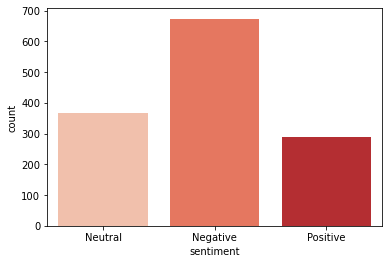

In [192]:
import seaborn as sns
sns.countplot(x='sentiment', data=df1, palette="Reds")

We can see that there are more news with Negative sentiment. 

### Check correlation between the followers and polarity scores

In [207]:
df1['polarity_score'].corr(df1['author_followers'])

0.053717506122658236

In [201]:
df1['growth_fllrs'] = - df1["author_followers"].diff() 

In [206]:
df1['polarity_score'].corr(df1['growth_fllrs'])

-0.013769205519999517

In [193]:
df1['sentiment'] = np.where(df1['polarity_score']>0.05, 1, 
                          np.where(df1['polarity_score']< -0.05, -1, 0))

In [194]:
df1['sentiment'].corr(df1['author_followers'])

0.04273945202796756

In [204]:
df1['sentiment'].corr(df1['growth_fllrs'])

-0.014494483034324568

<AxesSubplot:xlabel='author_followers', ylabel='polarity_score'>

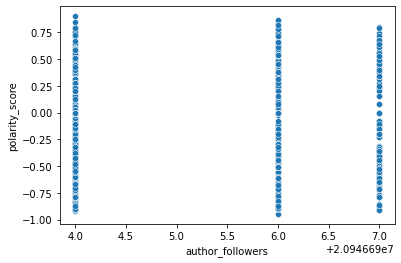

In [220]:
sns.scatterplot(data=df1, x="author_followers", y="polarity_score")

As we can see, correlation is very low. Partially the reason is that there is no variability in the followers number. For such a short period, the number of followers increased and decreased several times by 1-2 followers.

## NYTimes data

In [209]:
df2['polarity_score'] = df2['text'].apply(lambda x: sentiment.polarity_scores(str(x))['compound'])
df2['sentiment'] = np.where(df2['polarity_score']>0.05, "Positive", 
                          np.where(df2['polarity_score']< -0.05, "Negative", 'Neutral'))

<AxesSubplot:xlabel='sentiment', ylabel='count'>

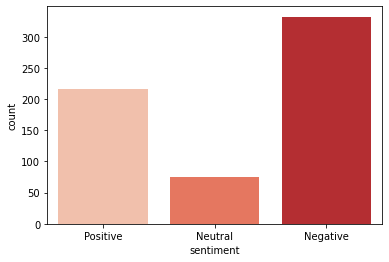

In [210]:
import seaborn as sns
sns.countplot(x='sentiment', data=df2, palette="Reds")

We can see that there are more news with Negative sentiment. 

### Check correlation between the followers and polarity scores

In [211]:
df2['polarity_score'].corr(df2['author_followers'])

-0.03855869395832605

In [212]:
df2['growth_fllrs'] = - df2["author_followers"].diff() 

In [213]:
df2['polarity_score'].corr(df2['growth_fllrs'])

-0.04998106407665556

In [217]:
df2['sentiment'] = np.where(df2['polarity_score']>0.05, 1, 
                          np.where(df2['polarity_score']< -0.05, -1, 0))

In [218]:
df2['sentiment'].corr(df2['author_followers'])

-0.03424046821084184

In [219]:
df2['sentiment'].corr(df2['growth_fllrs'])

-0.051811868839908584

<AxesSubplot:xlabel='author_followers', ylabel='polarity_score'>

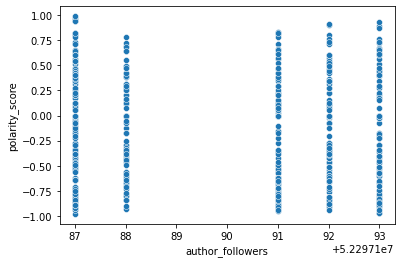

In [136]:
sns.scatterplot(data=df2, x="author_followers", y="polarity_score")

As we can see, correlation is very low. Partially the reason is that there is no variability in the followers number. For such a short period, the number of followers increased and decreased several times by 1-2 followers.